In [267]:
import pandas as pd 
import re
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm 
import seaborn as sns
from geopy.distance import geodesic

In [23]:
IN_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWithClustNums.tsv"

#we are bringing in the data with demographic information and cluster ids 
#hence, merged
#MVP path merged = pd.read_csv("/shared/3/projects/benlitterer/localNews/data/interim/SingleNE_85_clustered.tsv", sep="\t")
merged = pd.read_csv(IN_PATH, sep="\t")
merged = merged.dropna(subset=["clustNum"])


/opt/anaconda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3418: DtypeWarning: Columns (2,3,10,11,12,13,14,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [26]:
#look at which outlet first started a story 

#first make sure we have the date of an outlet correctly specified 
merged["date"] = pd.to_datetime(merged["date"])

"""
#group data together 
grouped = merged[["key", "source", "title", "content", "clustNum", "date", "national"]].groupby(by="clustNum").agg(list)
grouped["clustLen"] = grouped["key"].apply(len)

#get first to publish within a cluster 
grouped["first"] = grouped["date"].apply(lambda x: x.index(min(x)))
"""

'\n#group data together \ngrouped = merged[["key", "source", "title", "content", "clustNum", "date", "national"]].groupby(by="clustNum").agg(list)\ngrouped["clustLen"] = grouped["key"].apply(len)\n\n#get first to publish within a cluster \ngrouped["first"] = grouped["date"].apply(lambda x: x.index(min(x)))\n'

In [27]:
merged.columns

Index(['Unnamed: 0', 'key', 'local_id', 'sourcedomain_id', 'date', 'title',
       'content', 'url', 'fips', 'source', 'description', 'onlinesince',
       'rank', 'state', 'city', 'lon', 'lat', 'county', 'total_population',
       'white_pct', 'black_pct', 'hispanic_pct', 'nonwhite_pct',
       'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'predrt_0', 'predrt_12', 'predrt_3',
       'national', 'id', 'author', 'published', 'published_utc',
       'collection_utc', 'year', 'clustNum'],
      dtype='object')

In [29]:
#demVars = ["clustNum", "lon", "lat", "total_population", "white_pct", "black_pct", "rural_pct", "lesscollege_pct", "median_hh_inc", "age65andolder_pct"]

#variables that we will merge into graph after creating it
#in networkx
demVars = ["clustNum", "source"]

In [30]:
#get pairwise information
#by sorting in this way then calling drop_duplicates, we only consider the first mention of a story by 
#an outlet. Simplifies the analysis but introduces an assumption 
#example: merged.head(300)[["clustNum", "source", "date"]].sort_values(["clustNum", "source", "date"]).head(20)
pairwise = merged.sort_values(["clustNum", "source", "date"]).drop_duplicates(subset=["clustNum", "source"])

#group into clusters
pairwise = pairwise.loc[pairwise["national"] == False, ["key"] + demVars]
pairwise = pairwise.groupby(by="clustNum").agg(list)
pairwise["clustSize"] = pairwise["source"].apply(len)

#NOTE: we remove very large clusters? because they slow down getting pairwise information 
pairwise = pairwise[pairwise["clustSize"] < 2000].drop(columns=["clustSize"])

In [31]:
len(pairwise)

83491

In [32]:
def getPairwise(inList):
    outList = []
    for i in range(0, len(inList)-1): 
        for j in range(i + 1, len(inList)): 
            outList.append((inList[i], inList[j]))
    return outList

#applied across an entire series 
def getPairwiseSeries(inSeries): 
    return inSeries.apply(getPairwise)

pairwise["source"] = pairwise["source"].apply(getPairwise)
pairwise = pairwise.explode(["source"])
#pairwise[["date1", "date2"]] = pd.DataFrame(pairwise["date"].tolist(), index=pairwise.index)

In [33]:
pairwise.head()

,source
clustNum,
0.0,"(albuquerquejournal, aurorasentinel)"
0.0,"(albuquerquejournal, dailyherald)"
0.0,"(albuquerquejournal, murrysvillestar)"
0.0,"(albuquerquejournal, newyorkobserver)"
0.0,"(albuquerquejournal, pittsburghtribunereview)"


In [34]:
#TODO: figure out problem with missing rows here... 
#comes from explode() command

In [35]:
pairwise = pairwise.dropna()

In [36]:
merged[["source", "white_pct", "lesscollege_pct"]].drop_duplicates(["source"]).set_index("source")

,white_pct,lesscollege_pct
source,,
andalusiastarnews,83.5140077924143,85.0785142684584
atmoreadvance,60.5940594059406,88.3743498175607
thebrewtonstandard,60.5940594059406,88.3743498175607
clantonadvertiser,80.6102654220964,85.1454514881453
gadsdenmessenger,78.4313535791337,83.5081455032359
...,...,...
bnnbloomberg,NaN,NaN
trumptimes,NaN,NaN
sustainablepulse,NaN,NaN


In [381]:
multigraphDf = pairwise #NOTE: necessary? uses more memory...: .copy(deep=True)
multigraphDf[["source1", "source2"]] = pd.DataFrame(multigraphDf["source"].tolist(), index=multigraphDf.index)

#create graph from pandas dataframe. Allow parallel edges!
outletGraph = nx.from_pandas_edgelist(multigraphDf[["source1", "source2"]], source="source1", target="source2", create_using=nx.MultiGraph)

#add node attributes (i.e. population etc... ) to nodes that represent local outlets 
onlyLocal = merged[merged["national"] == False].drop_duplicates(subset="source") 

#get national/local 
#CHECKED that this works correctly 
#TODO: just add all of the note attributtes that we want in this step
#don't deal with them up above 
localNatDict = merged[["source", "white_pct", "lesscollege_pct", "median_hh_inc", "rural_pct", "age65andolder_pct", "total_population"]].drop_duplicates(["source"]).set_index("source").to_dict(orient="index")

In [382]:
#NOTE: important step 
#merge the fields of interest onto the graph 
nx.set_node_attributes(outletGraph, localNatDict)

In [384]:
#TODO: extend to have everything we're interested in 
#we use this to merge demographic variables onto our configuration model network 
outletDf = merged[["source", "white_pct", "lesscollege_pct", "median_hh_inc", "rural_pct", "age65andolder_pct", "total_population", "lat", "lon"]].drop_duplicates(["source"]).drop_duplicates()

In [402]:
def renameLeft(left): 
    if left not in ["nLeft", "nRight"]: 
        return left + "Left"
    return left

def renameRight(right): 
    if right not in ["nLeft", "nRight"] and "Left" not in right: 
        return right + "Right"
    return right

demCats = ["white_pct", "lesscollege_pct", "median_hh_inc", "rural_pct", "age65andolder_pct", "total_population"]
demDiffs = {}
for i in tqdm(range(100)):

    #create config model 
    #the config model creates a graph with the number of in and out degrees that we see in our graph 
    #the nodes are random though, so we are assuming that there is no relationship between 
    #any node characteristics and their degrees 
    degree = [tup[1] for tup in outletGraph.degree()]
    configModel = nx.configuration_model(degree)

    #NOTE: we have a different number of edges now so we will need to scale by that! 
    configModel.remove_edges_from(nx.selfloop_edges(configModel))

    #set the config model to have the same nodes and attributes as the original model 
    nodeMapping = dict(zip(list(configModel.nodes()), list(outletGraph.nodes())))
    configModel = nx.relabel_nodes(configModel, nodeMapping)
    nx.set_node_attributes(configModel, localNatDict)

    #get the edges from the graph
    edgeDf = nx.to_pandas_edgelist(configModel, source="nLeft", target="nRight")

    #get attributes we're interested in 
    #localNatDf = merged[["source", "national"]].drop_duplicates()
    temp = pd.merge(edgeDf, outletDf, how="left", left_on="nLeft", right_on="source").rename(renameLeft, axis=1)
    temp = pd.merge(temp, outletDf, how="left", left_on="nRight", right_on="source").rename(renameRight, axis=1)
    
    #get rid of rows for which we have "None" strings for demographic characteristics
    temp = temp.replace("None", np.nan).dropna()
    
    #localNatDf = localNatDf.rename(columns={"source":"target"})
    #edgeDf = pd.merge(temp, localNatDf, how="right", on="target").rename(columns={"national":"national2"})

    #totalEdges = len(list(configModel.edges()))
    
    #get the mean difference in % of people with < college education 
    for currDem in demCats: 
        cDiff = temp[currDem + "Right"].astype(float) - temp[currDem + "Left"].astype(float)
        
        if i == 0: 
            #append the average difference in this demographic category 
            demDiffs[currDem] = [np.mean(cDiff.abs())]
        else: 
            demDiffs[currDem].append(np.mean(cDiff.abs()))
        

100%|██████████| 100/100 [22:18<00:00, 13.39s/it]


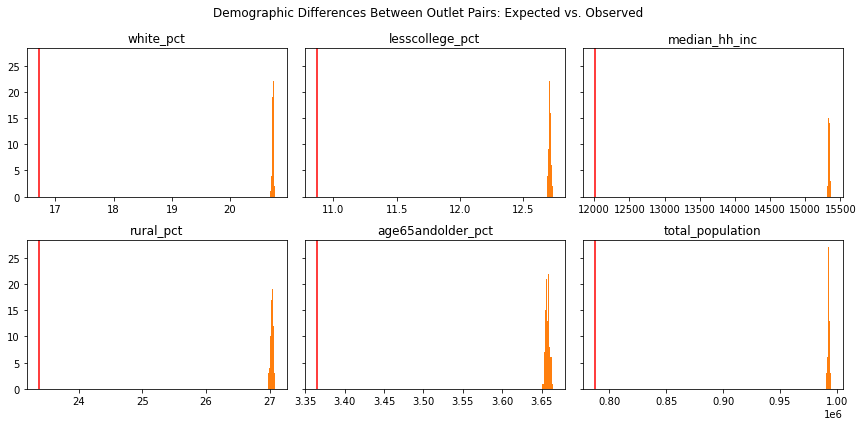

In [405]:
#now try a quick regression accounting for distance as well 
def renameLeft(inStr): 
    if "source" not in inStr and "sharedStories" not in inStr: 
        return inStr + "Left"
    return inStr

def renameRight(inStr): 
    if "source" not in inStr and "sharedStories" not in inStr and "Left" not in inStr: 
        return inStr + "Right"
    return inStr

nRows = 2
nCols = 3
fig, axs = plt.subplots(nrows=nRows, ncols=nCols, figsize=[12, 6], sharey=True)

count = 0
for i in range(nRows): 
    for j in range(nCols): 
        currDem = demCats[count]
        axs[i, j].hist(demDiffs[currDem])
        axs[i, j].set_title(currDem)
        count += 1
        
    
#merge demographic data onto our pairwise dataframe (edgeList)
temp = pd.merge(pairwise, outletDf, how="left", left_on="source1", right_on="source").drop(columns=["source_x", "source_y"]).rename(renameLeft, axis=1)
temp = pd.merge(temp, outletDf, how="left", left_on="source2", right_on="source").drop(columns=["source"]).rename(renameRight, axis=1)
temp = temp.replace("None", np.nan).dropna()

count = 0 
observedDiffs = []
for i in range(nRows): 
    for j in range(nCols): 
        currDem = demCats[count]
        
        #plot a histogram showing configuration distribution
        axs[i, j].hist(demDiffs[currDem])
        axs[i, j].set_title(currDem)
        
        #plot the difference we observe in our data 
        cDiff = temp[currDem + "Right"].astype(float) - temp[currDem + "Left"].astype(float)
        cDiff = np.mean(cDiff.abs())
        
        observedDiffs.append(cDiff)
        axs[i, j].axvline(cDiff, color="red")
        count += 1

fig.suptitle("Demographic Differences Between Outlet Pairs: Expected vs. Observed")
plt.tight_layout()


In [413]:
#get how national a cluster is 
clusterNatPercent = merged[["clustNum", "national"]].groupby(by=["clustNum"]).agg(np.mean).reset_index()

In [428]:
natPercentMerged = pd.merge(merged[["source", "clustNum"]], clusterNatPercent, on="clustNum", how="inner")
natPercents = natPercentMerged.drop_duplicates(subset=["source", "clustNum", "national"]).drop(columns=["clustNum"]).groupby("source").agg(np.mean).reset_index()

Text(0.5, 1.0, 'Outlet level national coverage')

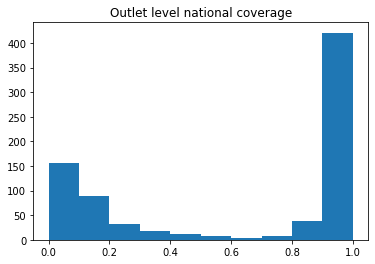

In [431]:
plt.hist(natPercents["national"])
plt.title("Outlet level national coverage")

In [496]:
#TODO: extend to have everything we're interested in 
#we use this to merge demographic variables onto our configuration model network 
outletDf = merged[["source", "white_pct", "lesscollege_pct", "median_hh_inc", "rural_pct", "age65andolder_pct", "total_population", "lat", "lon", "national", "state"]].drop_duplicates(["source"]).drop_duplicates()

outletDf = outletDf[outletDf["national"] == False].drop(columns=["national"])
#merge in degree data
degreeDf = pd.DataFrame.from_dict(dict(outletGraph.degree()), orient="index", columns=["degree"]).reset_index().rename(columns={"index":"source"})
outletDf = pd.merge(outletDf, degreeDf, on="source", how="left")

outletDf = pd.merge(outletDf, natPercents, on="source", how="left")

In [510]:
outletPairs = pairwise[["source1", "source2"]].copy(deep=True)
outletPairs[["source1", "source2"]] = np.sort(outletPairs[["source1", "source2"]], axis=1)
outletPairs["sharedStories"] = 1
outletPairs = outletPairs.groupby(by=["source1", "source2"]).agg(sum).reset_index()

In [511]:
outletPairs

,source1,source2,sharedStories
0,addisoncountyindependent,advertiserdemocrat,1
1,addisoncountyindependent,alamedatimesstar,1
2,addisoncountyindependent,alaskajournalofcommerce,1
3,addisoncountyindependent,albertleatribune,1
4,addisoncountyindependent,albuquerquejournal,2
...,...,...,...
46438,winstoncountyjournal,wisecountymessenger,1
46439,winstoncountyjournal,yellowspringsnews,1
46440,wisconsinnewspaperassociation,wisecountymessenger,1
46441,wisconsinnewspaperassociation,yellowspringsnews,1


In [512]:
#now try a quick regression accounting for distance as well 
def renameLeft(inStr): 
    if "source" not in inStr and "sharedStories" not in inStr: 
        return inStr + "Left"
    return inStr

def renameRight(inStr): 
    if "source" not in inStr and "sharedStories" not in inStr and "Left" not in inStr: 
        return inStr + "Right"
    return inStr

#merge in outlet level data 
outletPairs = pd.merge(outletPairs.reset_index(), outletDf, how="left", left_on="source1", right_on="source").drop(columns=["source"]).rename(renameLeft, axis=1)
outletPairs = pd.merge(outletPairs, outletDf, how="left", left_on="source2", right_on="source").drop(columns=["source"]).rename(renameRight, axis=1)
outletPairs = outletPairs.replace("None", np.nan).dropna()

In [514]:
#categories to go in our regression 
demCats = ["lesscollege_pct", "white_pct", "median_hh_inc", "rural_pct", "age65andolder_pct", "total_population","degree"]
for cat in demCats: 
    outletPairs[cat + "Diff"] = (outletPairs[cat + "Right"].astype(float) - outletPairs[cat + "Left"].astype(float)).abs()
    

In [515]:
#total number of rural outlets 
ruralOutlets = len(set(pairwise["source1"].unique()).union(set(pairwise["source2"])))
ruralPairs = ruralOutlets**2

pairedOutlets = len(outletPairs)

pairedOutlets / ruralPairs

0.47077677029807385

In [516]:
outletPairs["dist"] = outletPairs[["latLeft", "lonLeft", "latRight", "lonRight"]].apply(lambda x: geodesic((x["latLeft"], x["lonLeft"]), (x["latRight"], x["lonRight"])).miles, axis=1)

In [517]:
outletPairs["nationalMean"] = (outletPairs["nationalRight"] + outletPairs["nationalLeft"]) / 2

In [521]:
outletPairs["sameState"] = (outletPairs["stateRight"] == outletPairs["stateLeft"]).astype(int)

Text(0, 0.5, '# of co-reported stories')

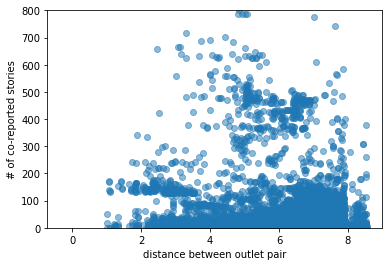

In [528]:
plt.scatter(np.log(outletPairs["dist"]), outletPairs["sharedStories"], alpha=.5)
#plt.xlim(-5, 100)
plt.ylim(0, 800)
plt.xlabel("distance between outlet pair")
plt.ylabel("# of co-reported stories")

In [444]:
outletPairs.columns

Index(['indexLeft', 'source1', 'source2', 'sharedStories', 'white_pctLeft',
       'lesscollege_pctLeft', 'median_hh_incLeft', 'rural_pctLeft',
       'age65andolder_pctLeft', 'total_populationLeft', 'latLeft', 'lonLeft',
       'degreeLeft', 'nationalLeft', 'white_pctRight', 'lesscollege_pctRight',
       'median_hh_incRight', 'rural_pctRight', 'age65andolder_pctRight',
       'total_populationRight', 'latRight', 'lonRight', 'degreeRight',
       'nationalRight', 'lesscollege_pctDiff', 'white_pctDiff',
       'median_hh_incDiff', 'rural_pctDiff', 'age65andolder_pctDiff',
       'total_populationDiff', 'degreeDiff', 'dist'],
      dtype='object')

Text(0, 0.5, 'count')

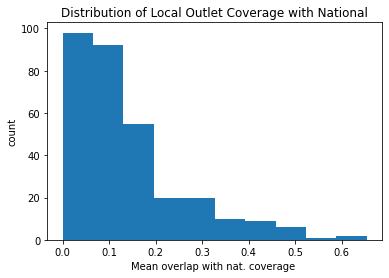

In [479]:
plt.hist(outletDf["national"])
plt.title("Distribution of Local Outlet Coverage with National")
plt.xlabel("Mean overlap with nat. coverage ")
plt.ylabel("count")

In [465]:
len(outletDf)

313

In [534]:
import statsmodels.formula.api as smf
mod = smf.ols('sharedStories ~ (lesscollege_pctDiff + white_pctDiff + median_hh_incDiff + rural_pctDiff +\
age65andolder_pctDiff + total_populationDiff) * sameState + dist + degreeDiff', data=outletPairs).fit()

In [535]:
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          sharedStories   R-squared:                       0.063
Model:                            OLS   Adj. R-squared:                  0.063
Method:                 Least Squares   F-statistic:                     205.2
Date:                Fri, 07 Apr 2023   Prob (F-statistic):               0.00
Time:                        09:39:18   Log-Likelihood:            -2.6015e+05
No. Observations:               45534   AIC:                         5.203e+05
Df Residuals:                   45518   BIC:                         5.205e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                          23.1856      1.086     21.343      0.000      21.056      25.315
lesscollege_pctDiff                -0.0737      0.041     -1.795      0.073      -0.154       0.007
white_pctDiff                      -0.0671      0.021     -3.150      0.002      -0.109      -0.025
median_hh_incDiff                  -0.0002   3.08e-05     -6.338      0.000      -0.000      -0.000
rural_pctDiff                      -0.0669      0.016     -4.277      0.000      -0.098      -0.036
age65andolder_pctDiff              -0.3859      0.107     -3.619      0.000      -0.595      -0.177
total_populationDiff             1.375e-06   2.83e-07      4.853      0.000     8.2e-07    1.93e-06
sameState                         123.7967      3.322     37.268      0.000     117.286     130.307
lesscollege_pctDiff:sameState       0.3043      0.215      1.415      0.157      -0.117       0.726
white_pctDiff:sameState            -1.6103      0.141    -11.438      0.000      -1.886      -1.334
median_hh_incDiff:sameState        -0.0022      0.000    -12.497      0.000      -0.003      -0.002
rural_pctDiff:sameState            -0.6825      0.091     -7.516      0.000      -0.860      -0.504
age65andolder_pctDiff:sameState     2.0978      0.578      3.627      0.000       0.964       3.231
total_populationDiff:sameState   9.361e-06   1.49e-06      6.287      0.000    6.44e-06    1.23e-05
dist                               -0.0027      0.001     -5.137      0.000      -0.004      -0.002
degreeDiff                         -0.0002   6.92e-05     -3.606      0.000      -0.000      -0.000
==============================================================================
Omnibus:                   136734.288   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      32599074582.911
Skew:                          43.493   Prob(JB):                         0.00
Kurtosis:                    4147.238   Cond. No.                     1.48e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.48e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [160]:
#note we have 45,534 unique pairs of outlets 
len(demPairs[["source1", "source2", "latLeft"]].groupby(by=["source1", "source2"]).agg(list))

45534

In [170]:
demPairs["same"] = 1

In [182]:
#generate random pairs of outlets that aren't in here 
#we can't select any pairs present in this dictionary 
noMatchDict = demPairs[["source1", "source2"]].groupby(by=["source1"]).agg(set).to_dict(orient="index")

In [185]:
allOutlets = set(demPairs["source1"].unique()).union(set(demPairs["source2"].unique()))

In [187]:
len(allOutlets)

308